# **Capstone Project - The Battle of Neighborhoods**

In this project we will try to find best place in Toronto having Indian Cuisine and Ideal place to invest in an Indian Restaurant.

We will import the required libraries for python.

* Pandas and numpy for handling data.
* Request module for using FourSquare API.
* Geopy to get co-ordinates of Toronto.
* Folium to visualize the results on a map.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
!pip install beautifulsoup4
from bs4 import BeautifulSoup as bs
!pip install geocoder
import geocoder
import os
import folium # map rendering library
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 122kB 5.4MB/s eta 0:00:01
     |████████████████████████████████| 102kB 6.5MB/s ta 0:00:011
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB 

Now we will define a function to get the geocodes i.e latitude and longitude of a location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="to_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We will define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. This function will return us the venue id , venue name and category.

In [30]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'VDY5BUFMOOKIYSDYUQA5W2NQKWYIVUM4QQ40K5SYJMXK0W5F' # your Foursquare ID
    CLIENT_SECRET = 'NGWYHYPQXCNPTGHTZFIB5PFU3G3JIVTWQV1TF52CBMU3MIJ1' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details similar to like count , rating , tip counts for a given venue id. This will be used for ranking the venues.

In [79]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'VDY5BUFMOOKIYSDYUQA5W2NQKWYIVUM4QQ40K5SYJMXK0W5F' # your Foursquare ID
    CLIENT_SECRET = 'NGWYHYPQXCNPTGHTZFIB5PFU3G3JIVTWQV1TF52CBMU3MIJ1' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will get the Toronto city data such as Boroughs, Neighborhoods along with their latitude and longitude using wikipedia page for Postal Codes.

In [5]:
from urllib.request import urlopen

source = urlopen("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").read()
soup = bs(source, "html.parser")

table = soup.table

table_rows = table.find_all("tr")

postal_codes = []

for tr in table_rows:
    td = tr.find_all("td")
    row = [ i.text[:-1] for i in td]
    postal_codes.append(row)
    #print(row)

postal_codes.pop(0)

df = pd.DataFrame(postal_codes, columns=['PostalCode', 'Borough', 'Neighborhood'])

#Drop the rows where Borough is not assigned.
df.drop(df.index[df['Borough'] == 'Not assigned'],inplace=True)
df.reset_index(drop=True, inplace=True)

#Changing the Neigborhood name to Borough name where naighbourhood names Not Assigned
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned', df['Borough'], df['Neighborhood'])

#Creating Dataframe of PostalCodes and their Latitude and Longitudes.
df_lat = pd.read_csv('http://cocl.us/Geospatial_data')

#Merge both dataframes based on Postal Code and drop duplicate column of Postal code
df_to = pd.merge(df,df_lat, how = 'left', left_on='PostalCode',right_on='Postal Code')
df_to = df_to.drop('Postal Code',1)
df_to = df_to.drop('PostalCode',1)
df_to.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [6]:
df_to.shape

(103, 4)

There are total of 103 different Neighborhoods in Toronto

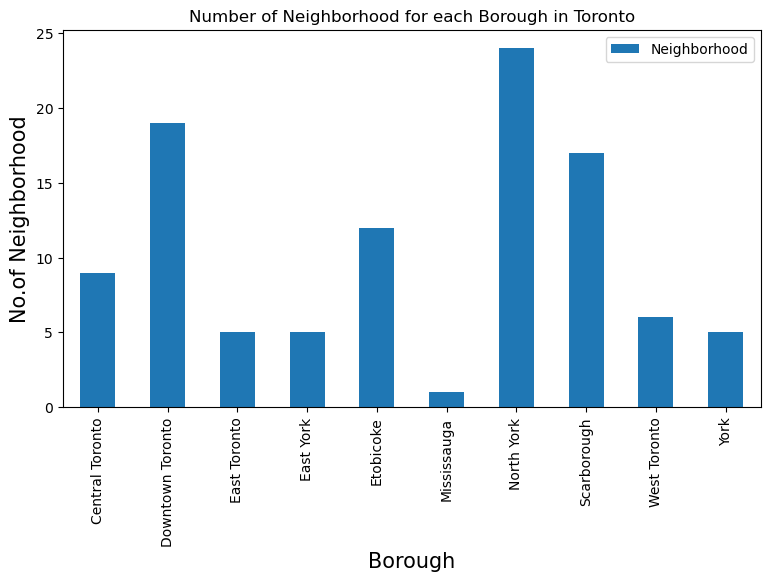

In [7]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_to.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can see that Toronto has 10 Boroughs and North York has maximum Neighborhoods

Now we will collect details of Indian resturants in each Neighborhood

In [8]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_to=pd.DataFrame(columns=column_names)
count=1
for row in df_to.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df_to),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_to = indian_rest_to.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Indian Resturants in Parkwoods, North York:0
( 2 / 103 ) Indian Resturants in Victoria Village, North York:0
( 3 / 103 ) Indian Resturants in Regent Park, Harbourfront, Downtown Toronto:2
( 4 / 103 ) Indian Resturants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 103 ) Indian Resturants in Queen's Park, Ontario Provincial Government, Downtown Toronto:1
( 6 / 103 ) Indian Resturants in Islington Avenue, Humber Valley Village, Etobicoke:0
( 7 / 103 ) Indian Resturants in Malvern, Rouge, Scarborough:0
( 8 / 103 ) Indian Resturants in Don Mills, North York:1
( 9 / 103 ) Indian Resturants in Parkview Hill, Woodbine Gardens, East York:0
( 10 / 103 ) Indian Resturants in Garden District, Ryerson, Downtown Toronto:0
( 11 / 103 ) Indian Resturants in Glencairn, North York:0
( 12 / 103 ) Indian Resturants in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 103 ) Indian Resturants in Rouge Hill, Port Union, Highland Creek, Scarboroug

Now that we have got all the Indian restaurants in Toronto , we will analyze it

In [9]:
indian_rest_to.head()

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,"Regent Park, Harbourfront",4af9a379f964a520c91222e3,Bombay Palace
1,Downtown Toronto,"Regent Park, Harbourfront",52af6dc5498e33995b0bbf03,Sultan Of Samosas
2,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4bedf8b5e24d20a17b567214,Kothur Indian Cuisine
3,North York,Don Mills,5c229362a0215b002cb89eb2,Butter Chicken Roti
4,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro


In [10]:
indian_rest_to.shape

(50, 4)

We got 50 Indian Resturants across Toronto Neighborhoods

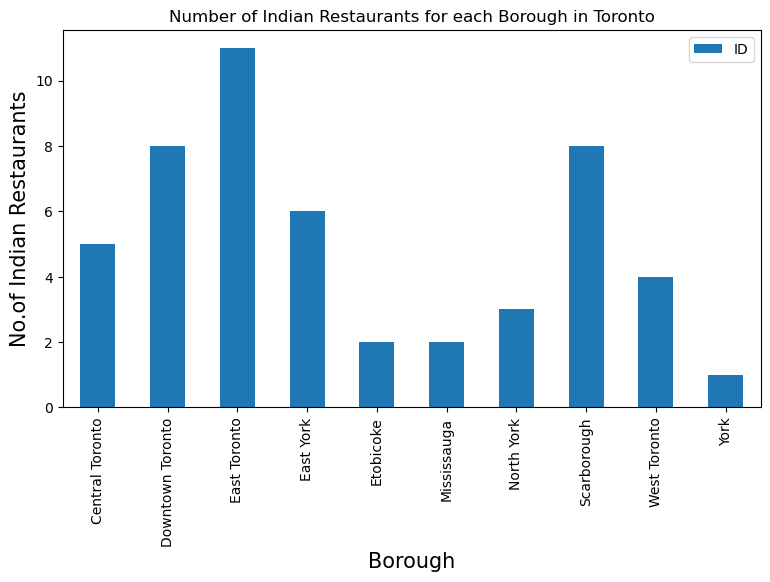

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_to.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can note that East Toronto has Highest number of Indian Restaurants.

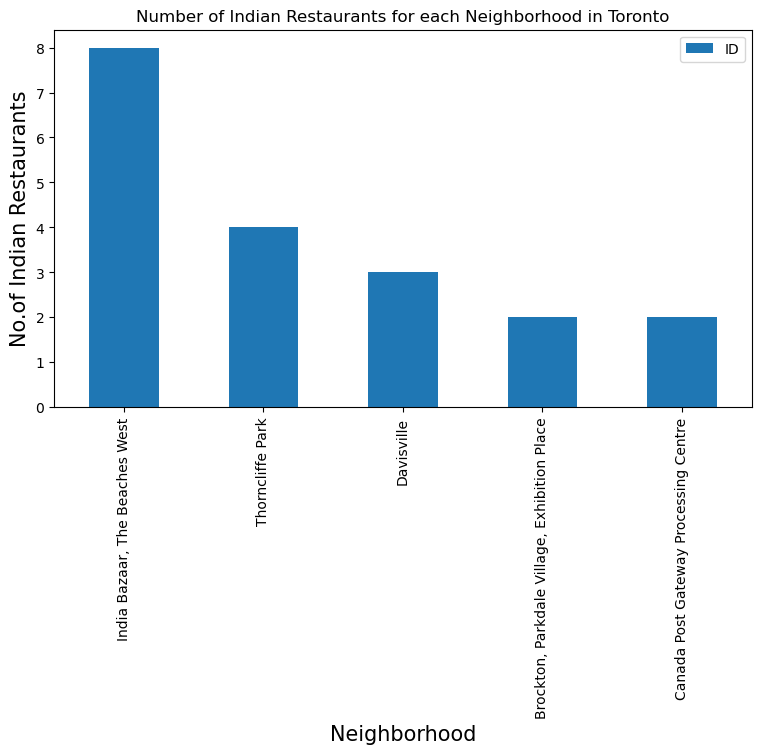

In [82]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_to.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [14]:
indian_rest_to[indian_rest_to['Neighborhood']=='India Bazaar, The Beaches West']

,Borough,Neighborhood,ID,Name
21,East Toronto,"India Bazaar, The Beaches West",4ae0c7a8f964a520638221e3,Udupi Palace
22,East Toronto,"India Bazaar, The Beaches West",4afc9816f964a520312422e3,Motimahal
23,East Toronto,"India Bazaar, The Beaches West",4bac30a2f964a52018ea3ae3,Bombay Chowpatty
24,East Toronto,"India Bazaar, The Beaches West",4ad9052cf964a520301721e3,Regency Restaurant
25,East Toronto,"India Bazaar, The Beaches West",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000
26,East Toronto,"India Bazaar, The Beaches West",4d8d278a1d06b1f712942a3b,Gautama
27,East Toronto,"India Bazaar, The Beaches West",4ae4c793f964a5201b9e21e3,The Famous Indian Restaurant
28,East Toronto,"India Bazaar, The Beaches West",4edd30c09adfe5cbe2818dc4,Lahori Taste & Burger House


We can note that India Bazaar, The Beaches West in East Toronto has highest Indian Restaurents with total count of 8.

Now we will get the ranking of each restaurants for further analysis.

In [80]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_to=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_to.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_to),')','processed')
    indian_rest_stats_to = indian_rest_stats_to.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

KeyError: 'venue'

In [39]:
indian_rest_stats_to.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,"Regent Park, Harbourfront",4af9a379f964a520c91222e3,Bombay Palace,14,7.5,13
1,Downtown Toronto,"Regent Park, Harbourfront",52af6dc5498e33995b0bbf03,Sultan Of Samosas,9,6.7,4
2,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,8.0,19
3,North York,Don Mills,0,0,0,0.0,0
4,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.9,3


In [40]:
indian_rest_stats_to.shape

(50, 7)

In [41]:
indian_rest_to.shape

(50, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [42]:
indian_rest_stats_to.to_csv('indian_rest_stats_to.csv', index=False)

Lets verify the data from saved csv file

In [43]:
indian_rest_stats_to_csv=pd.read_csv('indian_rest_stats_to.csv')

In [44]:
indian_rest_stats_to_csv.shape

(50, 7)

In [45]:
indian_rest_stats_to_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,"Regent Park, Harbourfront",4af9a379f964a520c91222e3,Bombay Palace,14,7.5,13
1,Downtown Toronto,"Regent Park, Harbourfront",52af6dc5498e33995b0bbf03,Sultan Of Samosas,9,6.7,4
2,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,8.0,19
3,North York,Don Mills,0,0,0,0.0,0
4,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.9,3


In [49]:
indian_rest_stats_to_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     int64  
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ KB


Here the data types looks correct, so no need of changing data types

In [50]:
# Resturant with maximum Likes
indian_rest_stats_to_csv.iloc[indian_rest_stats_to_csv['Likes'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                142
Rating                               8.6
Tips                                  75
Name: 8, dtype: object

In [51]:
# Resturant with maximum Rating
indian_rest_stats_to_csv.iloc[indian_rest_stats_to_csv['Rating'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                142
Rating                               8.6
Tips                                  75
Name: 8, dtype: object

In [52]:
# Resturant with maximum Tips
indian_rest_stats_to_csv.iloc[indian_rest_stats_to_csv['Tips'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                142
Rating                               8.6
Tips                                  75
Name: 8, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [53]:
to_neighborhood_stats=indian_rest_stats_to_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
to_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [84]:
to_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
2,West Toronto,"High Park, The Junction South",43.661608,-79.464763,8.3,"High Park, The Junction South, West Toronto(8.3)"
4,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.3,"St. James Town, Cabbagetown, Downtown Toronto(..."
0,Downtown Toronto,Christie,43.669542,-79.422564,8.2,"Christie, Downtown Toronto(8.2)"
1,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.0,"Church and Wellesley, Downtown Toronto(8.0)"
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8.0,"Queen's Park, Ontario Provincial Government, D..."
5,Scarborough,"Wexford, Maryvale",43.750072,-79.295849,8.0,"Wexford, Maryvale, Scarborough(8.0)"


These are the top neighborhoods with top average rating of Indian resturants in Toronto

In [56]:
to_borough_stats=indian_rest_stats_to_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
to_borough_stats.columns=['Borough','Average Rating']
to_borough_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Average Rating
8,West Toronto,7.800000
1,Downtown Toronto,7.750000
0,Central Toronto,7.460000
4,Etobicoke,7.000000
5,Mississauga,6.350000
9,York,6.200000
7,Scarborough,5.337500
2,East Toronto,5.072727
3,East York,4.550000
6,North York,4.466667


Similarly these are the average rating of Indian Resturants for each Borough in Toronto

Lets Visualize it by Graph

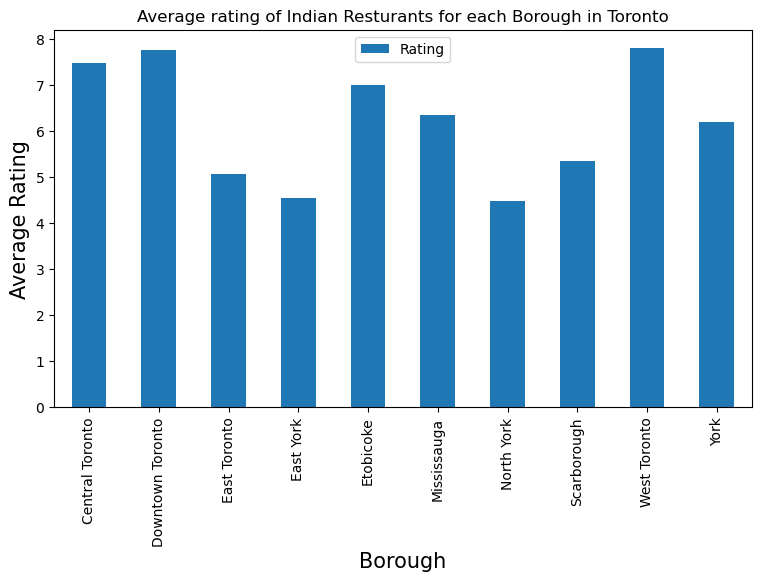

In [58]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_to_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map

In [59]:
to_neighborhood_stats=to_neighborhood_stats[to_neighborhood_stats['Average Rating']>=8.0]
to_neighborhood_stats

,Neighborhood,Average Rating
5,Christie,8.2
6,Church and Wellesley,8.0
12,"High Park, The Junction South",8.3
16,"Queen's Park, Ontario Provincial Government",8.0
20,"St. James Town, Cabbagetown",8.3
27,"Wexford, Maryvale",8.0


We will join this dataset to original Toronto data to get latitude and lonitude

In [60]:
to_neighborhood_stats=pd.merge(to_neighborhood_stats,df_to, on='Neighborhood')
to_neighborhood_stats=to_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
to_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Downtown Toronto,Christie,43.669542,-79.422564,8.2
1,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.0
2,West Toronto,"High Park, The Junction South",43.661608,-79.464763,8.3
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8.0
4,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.3
5,Scarborough,"Wexford, Maryvale",43.750072,-79.295849,8.0


Now we will plot this data on a map

In [85]:
# create map and display it
to_map = folium.Map(location=geo_location('Toronto, ON, Canada'), zoom_start=12)

In [86]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the Neighborhoods and add each to the incidents feature group
for lat, lng, in to_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [87]:
to_neighborhood_stats['Label']=to_neighborhood_stats['Neighborhood']+', '+to_neighborhood_stats['Borough']+'('+to_neighborhood_stats['Average Rating'].map(str)+')'

In [90]:
# add pop-up text to each marker on the map
for lat, lng, label in to_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(to_map)        
# add incidents to map
to_map.add_child(incidents)

### **Conclusion**

* Christie and St. James Town, Cabbagetown in Downtown Toronto and High Park, The Junction South in West Toronto are some of the good neighborhoods for having Indian Cuisine.
* West Toronto and Downtown Toronto has potential Indian Restaurant Market.
* North York ranks last in average rating of Indian Restaurants.
* Downtown Toronto is the best place to stay if you prefer Indian Cuisine.

### **Limitations**

* The ranking is purely on basis of rating of restaurants.
* The accuracy of data depends purely on the data provided by FourSquare Database.